In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy

from sys import path
path.append('../../')
from kooplearn.estimators import ReducedRank
from kooplearn.kernels import RBF, Matern, Linear

from Logistic import LogisticMap
from Lorenz63 import Lorenz63
from NoisyLinearSystem import NoisyLinear

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 9
})

### Error plots

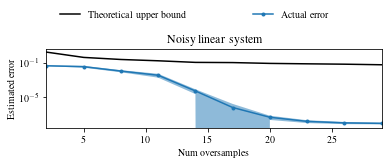

In [4]:
data = [ pickle.load(open(f"data/randSVD_errorbounds.pkl", "rb"))]
titles = ['Noisy linear system']

fig_width = 5.5 #Inches
fig_height = 2 #Inches


fig, axes = plt.subplots(ncols=len(data), figsize=(fig_width, fig_height))

for idx in range(len(data)):
    if len(data) == 1:
        ax = axes
    else:
        ax = axes[idx]
    results = data[idx]
    
    target_ranks = results['target_ranks']
    th_estimate = results['th_estimate']
    means = results['means']
    stds = results['stds']
    
    ax.plot(target_ranks, th_estimate, 'k-', label='Theoretical upper bound')
    ax.plot(target_ranks, means, '.-', label='Actual error')
    ax.fill_between(target_ranks, (means - stds), (means + stds), alpha=0.5)

    ax.set_ylabel("Estimated error")
    ax.set_xlabel("Num oversamples")
    ax.set_yscale('log')
    ax.set_title(titles[idx])
    ax.set_xmargin(0)

fig.legend(bbox_to_anchor=(0.15, 1, 0.7, 0.2), borderaxespad=0, loc='lower center', mode='expand', ncol=3, frameon=False)
plt.tight_layout()
#fig.savefig("figs/randomizedSVD_benchmarks.pdf",  bbox_inches='tight')


### Benchmarks plot

In [9]:
data = [ pickle.load(open(f"data/{fname}_randSVD_benchmarks.pkl", "rb")) for fname in ['noisylinear']]
titles = ['Noisy linear system']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


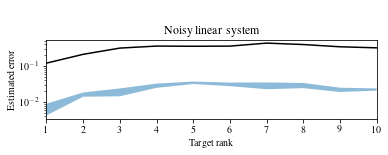

In [5]:

fig_width = 5.5 #Inches
fig_height = 2 #Inches

#Hardcoded
n_oversamples = data[0]['n_oversamples']
iterated_power = data[0]['iterated_power']

fig, axes = plt.subplots(ncols=len(data), figsize=(fig_width, fig_height))

for idx in range(len(data)):
    if len(data) == 1:
        ax = axes
    else:
        ax = axes[idx]
    results = data[idx]
    
    solvers = results['solvers']
    means = results['means']
    stds = results['stds']
    iter_arr = results['iterated_array']

    for solver_idx, solver in enumerate(solvers):
        if solver == 'randomized':
            label = solver.capitalize() + f" p={iterated_power}, s={n_oversamples}"
        else:
            label = solver.capitalize()
        if idx == 0:
            ax.plot(iter_arr, means[solver_idx], '.-', label=label)
        else:
            ax.plot(iter_arr, means[solver_idx], '.-')
        ax.fill_between(iter_arr, (means - stds)[solver_idx], (means + stds)[solver_idx], alpha=0.5)
    ax.set_ylabel("time (s)")
    ax.set_xlabel("Sample size")
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(titles[idx])
    ax.set_xmargin(0)

fig.legend(bbox_to_anchor=(0.15, 1, 0.7, 0.2), borderaxespad=0, loc='lower center', mode='expand', ncol=3, frameon=False)
plt.tight_layout()
#fig.savefig("figs/randomizedSVD_benchmarks.pdf",  bbox_inches='tight')

### Estimator consistency check: Lorenz63

In [5]:
params = {
    #Lorenz63
    'kernel': Linear(coef0=0),
    'backend': 'keops',
    'rank': 10,
    'tikhonov_reg': 1e-5,
    'n_oversamples': 2,
    'iterated_power': 1
}
ndim = 50
seed = 0 #Reproducibility
random_basis_change = scipy.stats.special_ortho_group.rvs(ndim, random_state=seed)
temperature = 0.2
eigenvalues = 0.5*(1 - np.tanh(np.linspace(-2, 2, ndim)/temperature))
A = random_basis_change.T.dot(np.diag(eigenvalues)).dot(random_basis_change)
map = NoisyLinear(stability = 0.999, A = A)

sample_size = 7500

In [6]:
X, Y = map.sample(size = sample_size, scale_output=True, iid = False)

In [7]:
rand_estimator = ReducedRank(**params, svd_solver='randomized').fit(X,Y)

In [66]:
estimator = ReducedRank(**params, svd_solver='arnoldi').fit(X, Y)

In [45]:
numerical_eigs = estimator.eig(left=False, right=False)
rand_numerical_eigs = rand_estimator.eig(left=False, right=False)

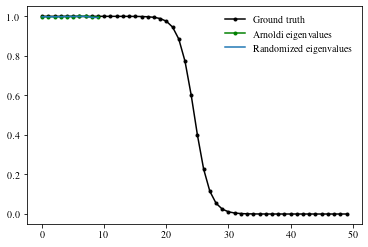

In [46]:
plt.plot(eigenvalues, 'k.-', label = 'Ground truth')
plt.plot(numerical_eigs.real[::-1], 'g.-', label = 'Arnoldi eigenvalues')
plt.plot(rand_numerical_eigs[::-1].real, label ='Randomized eigenvalues')
plt.legend(frameon=False)